<a href="https://colab.research.google.com/github/xychong/edgeaimonitoring/blob/main/MobileNet_V2_Training_%5BUnfreeze_Layers%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow.compat.v2 as tf
import keras
from keras.models import Sequential
from keras.applications import mobilenet_v2

import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
print(tf.__version__)

2.6.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
train_data = np.load("/content/drive/MyDrive/FYP Data/Train and Test/train_data.npy", allow_pickle = True)
test_data = np.load("/content/drive/MyDrive/FYP Data/Train and Test/test_data.npy", allow_pickle = True)
train_label = np.load("/content/drive/MyDrive/FYP Data/Train and Test/train_label.npy", allow_pickle = True)
test_label = np.load("/content/drive/MyDrive/FYP Data/Train and Test/test_label.npy", allow_pickle = True)

In [5]:
print(train_data.shape)
print(test_data.shape)
print(train_label.shape)
print(test_label.shape)

(1204, 224, 224, 3)
(304, 224, 224, 3)
(1204, 1)
(304, 1)


In [6]:
original_model = keras.applications.mobilenet_v2.MobileNetV2()

In [7]:
# Original MobileNetV2 architecture
original_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [8]:
from keras.applications.mobilenet_v2 import MobileNetV2
from keras import optimizers
from keras.models import Model
from keras.layers import Input, Conv2D, GlobalAveragePooling2D, Dropout, Dense
from keras.layers import Activation, BatchNormalization, Add, Reshape, DepthwiseConv2D

### We only want to fine-tune a small number of top layers 
### The higher the layer is, the more specialized it is
### First few layers learn very simple and generic features that generalize to almost all types of data
### Features in higher layers are more specific to the dataset on which model was trained
### Goal of fine tuning is to adapt these specialized features to work with new dataset
### Fine tuning too many layers may lead to overfitting

https://www.tensorflow.org/tutorials/images/transfer_learning
https://blog.roboflow.com/how-to-train-mobilenetv2-on-a-custom-dataset/

In [9]:
# Create base model from pre-trained model MobileNetV2
base_model = MobileNetV2(input_shape=(224,224,3), include_top=False)

# Unfreeze the base model
base_model.trainable = True

# Observe how many layers are in the base model
# 154
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 152

# Freeze all layers before 'fine_tune_at' layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

for layer in base_model.layers:
  print(layer, layer.trainable)

# Base model architecture
# base_model.summary()

Number of layers in the base model:  154
<keras.engine.input_layer.InputLayer object at 0x7fec083fe390> False
<keras.layers.convolutional.Conv2D object at 0x7fec046d0c50> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fec0475e250> False
<keras.layers.advanced_activations.ReLU object at 0x7fec083fea90> False
<keras.layers.convolutional.DepthwiseConv2D object at 0x7fec046cba90> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fec046597d0> False
<keras.layers.advanced_activations.ReLU object at 0x7fec046d4790> False
<keras.layers.convolutional.Conv2D object at 0x7fec046cab10> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fec04667750> False
<keras.layers.convolutional.Conv2D object at 0x7fec0466ba10> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fec04667590> False
<keras.layers.advanced_activations.ReLU object at 0x7fec0471e6d0> False
<

In [10]:
base_model.output

<KerasTensor: shape=(None, 7, 7, 1280) dtype=float32 (created by layer 'out_relu')>

https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/

In [11]:
## Adding additional layers

# Applies average pooling on spatial dimensions
# shape (None, 1280)
x = GlobalAveragePooling2D()(base_model.output) 

# Reshape (None, 1280) to (1, 1, 1280)
x = Reshape((1, 1, 1280))(x)

# Apply a Dropout
# Randomly selected neurons are ignored during training; helps prevent overfitting
# Dropout doesn't have any variables/weights that can be frozen during training
x = Dropout(0.3, name='Dropout')(x) 

# 2D convolutional layer
# Shape (1,1,5)
x = Conv2D(5, (1, 1), padding='same', data_format = 'channels_last')(x)

# Feeds all outputs from previous layers to all neurons
x = Activation('softmax', name='softmax')(x)  

# Reshape (1,1,5) to (,5)
# 5 represents the 5 sound classes
x = Reshape((5,))(x)

model = Model(inputs = base_model.inputs, outputs = x)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [12]:
model.output_shape

(None, 5)

In [13]:
# Number of trainable variables
len(model.trainable_variables)

4

In [14]:
# Configuring the model
# Use crossentropy loss function when there are two or more label classes
# Labels are provided as integers
# Adjust learning rate to reduce loss
#model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

opt = tf.keras.optimizers.Adam(learning_rate=0.0003)
model.compile(optimizer = opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

### Underfitting: Validation Accuracy higher than Training Accuracy

### Overfitting: Validation Loss much higher than Training Loss

In [15]:
# Train the model
initial_epochs = 20
fine_tune_epochs = 20
total_epochs = initial_epochs + fine_tune_epochs
training = model.fit(train_data, train_label, epochs=total_epochs, validation_data=(test_data, test_label), verbose=1)

Epoch 1/40
38/38 [==============================] - 36s 884ms/step - loss: 1.3960 - accuracy: 0.4419 - val_loss: 1.1582 - val_accuracy: 0.5822
Epoch 2/40
38/38 [==============================] - 33s 885ms/step - loss: 0.8087 - accuracy: 0.7251 - val_loss: 0.9665 - val_accuracy: 0.6776
Epoch 3/40
38/38 [==============================] - 34s 888ms/step - loss: 0.6009 - accuracy: 0.8090 - val_loss: 0.8537 - val_accuracy: 0.7467
Epoch 4/40
38/38 [==============================] - 34s 891ms/step - loss: 0.4911 - accuracy: 0.8430 - val_loss: 0.7976 - val_accuracy: 0.7336
Epoch 5/40
38/38 [==============================] - 34s 890ms/step - loss: 0.4467 - accuracy: 0.8571 - val_loss: 0.7413 - val_accuracy: 0.7796
Epoch 6/40
38/38 [==============================] - 34s 888ms/step - loss: 0.3831 - accuracy: 0.8846 - val_loss: 0.6997 - val_accuracy: 0.7961
Epoch 7/40
38/38 [==============================] - 34s 900ms/step - loss: 0.3466 - accuracy: 0.8887 - val_loss: 0.6651 - val_accuracy: 0.8092

### Evaluate Performance of Classifier

In [16]:
test_loss, test_acc = model.evaluate(test_data, test_label)

print("Tested Acc:", test_acc)

10/10 [==============================] - 7s 693ms/step - loss: 0.2317 - accuracy: 0.9342
Tested Acc: 0.9342105388641357


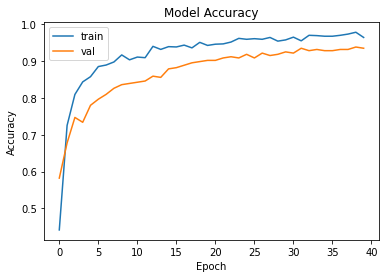

In [17]:
plt.plot(training.history['accuracy'])
plt.plot(training.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

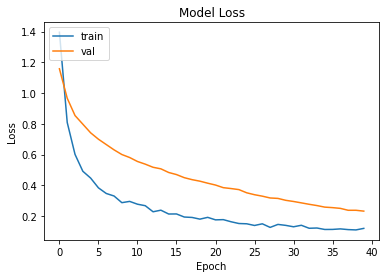

In [18]:
plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [19]:
test_label_predict = model.predict(test_data)

In [20]:
print(test_label_predict[0], np.argmax(test_label_predict[0]))

[0.70700544 0.20813017 0.00482021 0.06319323 0.0168509 ] 0


In [21]:
test_label_pred_array = []

count = 0
for item in test_label_predict:
  test_label_pred_array.append(np.argmax(test_label_predict[count]))
  count+=1

print(count)
#test_label_pred_array

304


In [22]:
print(test_label.shape)

(304, 1)


In [23]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(test_label, test_label_pred_array)
print('Confusion Matrix\n')
confusion

Confusion Matrix



array([[61,  3,  0,  1,  0],
       [ 0, 69,  0,  0,  0],
       [ 0,  0, 45,  2,  0],
       [ 0,  5,  1, 60,  3],
       [ 0,  0,  0,  5, 49]])

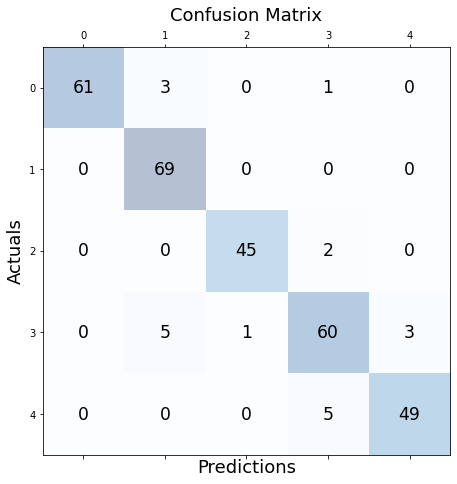

In [24]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(confusion, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion.shape[0]):
    for j in range(confusion.shape[1]):
        ax.text(x=j, y=i,s=confusion[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [25]:
# Precision = P/(TP+FP)
# Recall = TP/(TP+FN)
# F1 Score = (2 x precision x recall)/(precision + recall)
# Support: number of occurences of the class in the dataset
from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(test_label, test_label_pred_array, target_names=['Ambience', 'Footsteps', 'Horn', 'Music', 'Shout']))


Classification Report

              precision    recall  f1-score   support

    Ambience       1.00      0.94      0.97        65
   Footsteps       0.90      1.00      0.95        69
        Horn       0.98      0.96      0.97        47
       Music       0.88      0.87      0.88        69
       Shout       0.94      0.91      0.92        54

    accuracy                           0.93       304
   macro avg       0.94      0.93      0.94       304
weighted avg       0.94      0.93      0.93       304

